<a href="https://colab.research.google.com/github/dpetaz/hello-world/blob/master/2020_NeurIPS_tspDB_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tspDB Demo 

## Overview of tspDB

In this demonstration, we showcase the capabilities of tspDB; the time series predict DB (available at https://tspdb.mit.edu).

**tspDB**, built as an extension to PostgreSQL, enables state-of-the-art predictive query functionalities in any existing time-series relational DB. 



Specifically, tspDB enables two types of predictive queries for time series data: 
1. imputing a missing or noisy observation for a time series datapoint we do observe.
2. forecasting a time series data point in the future (i.e., data that is as of yet unobserved).  


### Prediction Index
Analogous to a standard DB index, tspDB enables users to fit a prediction model by building a **prediction index**, *a novel abstraction that we propose in our work*. Specifically, as a standard DB index allows for a faster retrieval for entries in the DB, a prediction index allows for fast retrieval for *predicted* entries.  


---
### Demonstration scenarios
In this notebook, we will go through the following demonstrations:

1. **3 Real-world use cases of tspDB.** 

    This is an end-to-end demo of using tspDB on several use-case scenarios. Specifically, We will showcase the following:
    1. How prediction capabilities are added through building **a prediction index**.
    2. How to inspect the accuracy of the built prediction index.
    3. How prediction queries are written in tspDB.
    4. How accurate these predictions are in each use case. 

2. **tspDB's Uncertainty Quantification Capabilities.**

    This demo illustrates tspDB's ability to recover the underlying time-varying mean and variance, and hence its ability to produce predictions with confidence intervals. We validate the results by comparing them with the true underlying variance in our synthetically generated data. 

3. **tspDB's Computational Performance.**
    This part demonstrates tspDB's computational performance. Specifically, we are interested in measuring tspDB's insert throughput and queries' latency and how they compare to PostgreSQL. 

To run this demo, you need to install tspDB and download the required datasets as is shown in the next two cells.


In [1]:
#@title Install tspDB
#@markdown Run this cell to install tspDB and its prerequisites. 
#@markdown Also, this cell create a database and a new user 'demo' with Superuser privileges.

#@markdown The last two lines should be  "CREATE EXTENSION" & "CREATE ROLE"  indicating that the installation process has bee successful.


!sudo apt-get install wget ca-certificates
!wget --quiet -O - https://www.postgresql.org/media/keys/ACCC4CF8.asc | sudo apt-key add -
!sudo sh -c 'echo "deb http://apt.postgresql.org/pub/repos/apt/ `lsb_release -cs`-pgdg main" >> /etc/apt/sources.list.d/pgdg.list'
!sudo apt-get update
!sudo apt-get install postgresql-plpython3-14

!service postgresql start
!sudo -u postgres psql -c "CREATE EXTENSION plpython3u;"
%cd /usr/lib/python3.6
!sudo curl https://bootstrap.pypa.io/pip/3.6/get-pip.py -o get-pip.py
!sudo apt-get install python3-distutils
!sudo python3.6 get-pip.py 
!hash -d pip3
!git clone https://github.com/AbdullahO/tspdb.git
!sudo pip3 install tspdb/.

!sudo cp tspdb/extension_py3/tspdb.control /usr/share/postgresql/14/extension/tspdb.control
!sudo cp tspdb/extension_py3/tspdb--0.0.1.sql /usr/share/postgresql/14/extension/tspdb--0.0.1.sql
!sudo -u postgres psql -c "CREATE EXTENSION tspdb;"
!sudo -u postgres psql -c "CREATE USER demo WITH  PASSWORD '00' SUPERUSER  "
# !sudo -u postgres psql -c "SELECT test_tspdb();"


Reading package lists... Done
Building dependency tree       
Reading state information... Done
ca-certificates is already the newest version (20211016ubuntu0.20.04.1).
wget is already the newest version (1.20.3-1ubuntu2).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
OK
Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://apt.postgresql.org/pub/repos/apt focal-pgdg InRelease [91.6 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:8 https://developer.downl

## Datasets
Next, run the next cell to download the datasets we're using for this demo.

In [2]:
# return to the content folder
%cd /content
# Download
!wget https://github.com/AbdullahO/tspdb/raw/master/notebook_examples/Demo/demo_data_v3.zip
# unzip
!unzip demo_data_v3.zip

/content
--2023-02-16 16:56:47--  https://github.com/AbdullahO/tspdb/raw/master/notebook_examples/Demo/demo_data_v3.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AbdullahO/tspdb/master/notebook_examples/Demo/demo_data_v3.zip [following]
--2023-02-16 16:56:47--  https://raw.githubusercontent.com/AbdullahO/tspdb/master/notebook_examples/Demo/demo_data_v3.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64685792 (62M) [application/zip]
Saving to: ‘demo_data_v3.zip’

demo_data_v3.zip    100%[===================>]  61.69M   290MB/s    in 0.2s    

2023-02-16 16:56:48 (290 MB/s) - ‘demo_data_

In [ ]:
# list files
!ls demo_data_v3/data/


electricity_05_noise.csv    retail_data_test.csv
electricity_50_missing.csv  retail_data_train.csv
electricity_80_missing.csv  retail_data_train_missing.csv
electricity.csv		    synthetic_ber.csv
electricity_test.csv	    synthetic_pois.csv
financial.csv		    synthetic_test.csv
financial_test.csv	    synthetic_var.csv
load_data.sql		    synthetic_var_test.csv



## DB connection

First, we need to connect to the PostgreSQL database. We Provide connection information below to a tspDB database that we just created.  

In [3]:
## fill your DB information

database = 'postgres'
user = 'demo'
password = '00'
host = 'localhost'
conn_string = "host='%s' dbname='%s' user='%s' password='%s'" %(host, database, user, password)

# Import the packages needed 
import time
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import norm

from sqlalchemy import create_engine
engine = create_engine('postgresql' + '://' + user + ':' + password + '@' + host + '/' + database)
conn_string = "host='%s' dbname='%s' user='%s' password='%s'" %(host, database, user, password)

# Some utilitiy functions
def rmse(y, y_h):
    return np.sqrt(np.mean(np.square(y_h - y)))


def r2(y, y_h, ave = None):
    if ave is None: ave = np.mean(y)
    ssa = np.square(y-y_h).sum()
    ssr = np.square(y-ave).sum()
    return 1-ssa/ssr




## Loading Data & Datasets Description

In the demonstrations below, we use different real-world and synthetic datasets. Specifically, we test tspDB's capabilities on the following DB tables:

**1. `electricity`.**

This table contains the hourly electricity load of 10 households for three years (~26,000 hours). The data is a subset of a public dataset [available at the UCI repository](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014).

**2. `retail`.** 

This table contains the weekly sales data for different departments at 10 Walmart stores. The data is a subset of a public dataset [available at Kaggle](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting).

**3.`financial`.**

This table contains the daily average stock prices for 839 publicly listed companies for 15 years. The data is obtained from Wharton Research Data Services (WRDS).

**4. `synthetic_var`.**

The time series in this table is synthetically generated from a Gaussian process with a time-varying mean and a time-varying variance. Both mean and variance are generated from a (different) sum of harmonics. 

Now we will load these tables into your PostgreSQL DB. **Run the next cell to do so:**

In [4]:
# Create Schemas
conn = psycopg2.connect(conn_string)
cur = conn.cursor()
cur.execute(open("demo_data_v3/load_data.sql", "r").read())
conn.commit()
conn.close()

# Copy tables from csv files
conn = psycopg2.connect(conn_string)
cur = conn.cursor()

files = ['synthetic_var.csv','electricity.csv','retail_data_train_missing.csv','financial.csv']
names = ["synthetic_var","electricity","retail","financial"]
for file_name, table_name in zip(files, names):
  cur.copy_from(open("demo_data_v3/data/%s"%file_name), table_name, null = "")
conn.commit()
conn.close()

## Part I: **Real-world use cases of tspDB.** 

### Use Case I: Forecasting Electricity Consumption
We will start with forecasting electricity demand, a common yet crucial application for time series data with huge economic and societal implications. 

In this use case, we will show how our proposed system can accurately forecast energy demand with minimal effort from the user. 


The goal here is to forecast the hourly electricity consumption for the next 72 hours for several houses. Such short-term forecasting is essential for the utility companies and electricity retail companies to accurately estimate the generation needed. 




In [ ]:
# set up connection
conn = psycopg2.connect(conn_string)

#### Inspect Dataset
First, we will inspect the table `electricity`. The table contains the hourly electricity consumption of 10 households. Each household's consumption is recorded in a separate column (e.g. `h1` for the first household). Each row represents the consumption at one specific hour as shown in the column `time`. 







For example, let's  inspect the last 10 entries in the table:

In [ ]:
# lets query our table `electricity` to inspect its data
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from electricity order by time DESC limit 10;", conn)
conn.close()
df

,time,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10
0,2014-12-18 00:00:00,801.047120,90.909091,62.664908,162.551440,1042.056075,154.237288,136.419001,431.183831,454.602379,224.834680
1,2014-12-17 23:00:00,1000.000000,100.249066,68.601583,222.908093,1397.196262,194.067797,165.651644,451.395573,507.827176,275.532697
2,2014-12-17 22:00:00,1015.706806,148.816936,98.284960,259.945130,1518.691589,196.610169,165.651644,509.143407,515.967439,328.434974
3,2014-12-17 21:00:00,986.910995,172.478207,107.519789,251.714678,1523.364486,201.694915,177.222899,574.590953,537.883532,287.288758
4,2014-12-17 20:00:00,1078.534031,242.839352,85.092348,218.792867,1822.429907,188.983051,180.267966,510.105871,614.902943,326.230713
5,2014-12-17 19:00:00,1089.005236,254.047323,74.538259,179.698217,1579.439252,144.915254,161.388551,438.883542,592.986850,247.612050
6,2014-12-17 18:00:00,921.465969,209.215442,48.153034,174.211248,1336.448598,108.474576,109.622412,329.162656,544.145272,178.545187
7,2014-12-17 17:00:00,740.837696,171.232877,35.620053,163.923182,869.158879,71.186441,87.697929,256.977863,482.154039,134.459956
8,2014-12-17 16:00:00,633.507853,166.251557,40.897098,163.923182,845.794393,73.728814,68.209501,241.578441,477.144646,132.990448
9,2014-12-17 15:00:00,612.565445,148.194271,36.939314,159.807956,822.429907,87.288136,66.991474,247.353224,487.789606,144.746510


Further, let's take a look at the hourly electricity consumption for `h1`, `h2`, and `h3`  from `2012-01-01 01:00:00` to `2014-12-18 00:00:00` (all the entries that exist in the DB):

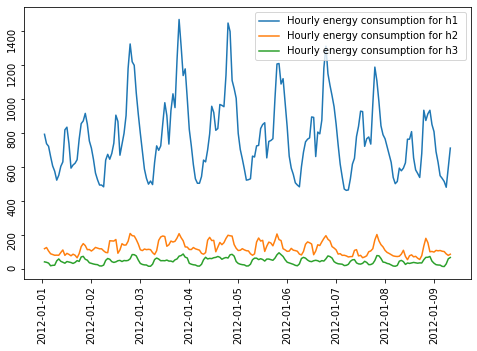

In [ ]:
# lets query our table `electricity` to inspect its data
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select time,h1,h2,h3 from electricity order by time ;", conn)
conn.close()
T_vis = 200
plt.figure(figsize = (8,5))
plt.plot(df['time'][:T_vis], df['h1'][:T_vis], label = 'Hourly energy consumption for h1 ')
plt.plot(df['time'][:T_vis], df['h2'][:T_vis], label = 'Hourly energy consumption for h2 ')
plt.plot(df['time'][:T_vis], df['h3'][:T_vis], label = 'Hourly energy consumption for h3 ')

plt.xticks(rotation = 90, color = 'black')
plt.yticks(rotation = 90, color = 'black')
plt.legend()
# plt.xlim([pd.Timestamp('2011-12-18 00:00:00'),pd.Timestamp('2014-12-18 00:00:00')])
plt.show()


#### Build Prediction Index
Now, we will create a **prediction index**, which we will call `pindex1` on the columns (`h1`, ..., `h10`). The creation of this prediction index allows for retrieving predicted values for columns  (`h1`, ..., `h10`) for entries that are: 

**1.** At a future time step (i.e. forecasting), 

**2.** Missing/corrupted by noise (i.e. imputation)

In addition to that, it will also estimate the underlying time-varying variance of the time series, which allows users to produce upper and lower bound for their prediction. 

Let's now build our pindex on the table `electricity`, using the time column `time` with the **tspDB** command: 

`select create_pindex('electricity', 'time','{"h1","h2","h3","h4","h5","h6","h7","h8","h9","h10"}','pindex1');`

In [ ]:
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("""select create_pindex('electricity', 'time','{"h1","h2","h3","h4","h5","h6","h7","h8","h9","h10"}','pindex1');""")
conn.commit()
conn.close()

With that, the prediction index **is built**. tspDB's allow users to inspect the predictive indices that have been built in the DB using the function ``list_pindices()``. 


In [ ]:
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from list_pindices();", conn)
df

,index_name,value_columns,relation,time_column,initial_timestamp,last_timestamp,agg_interval,uncertainty_quantification
0,pindex1,"[h1, h2, h3, h4, h5, h6, h7, h8, h9, h10]",electricity,time,2012-01-01 01:00:00,2014-12-18 00:00:00,01:00:00,True


Further, you can inspect the  in-sample (training) accuracy of your prediction index for *each time series* by using **tspDB's** function `pindices_stat()`. Note that the metric used is $R^2$ (a value of 1 corresponds to a perfect model and 0 corresponds to a model that simply use the mean as the estimate).

In [ ]:
df = pd.read_sql_query("select * from pindices_stat() where index_name = 'pindex1';", conn)
df

,index_name,column_name,number_of_observations,number_of_trained_models,imputation_score,forecast_score,test_forecast_score
0,pindex1,h1,25968,1,0.973906,0.962933,None
1,pindex1,h2,25968,1,0.949151,0.945548,None
2,pindex1,h3,25968,1,0.946575,0.935098,None
3,pindex1,h4,25968,1,0.971341,0.973539,None
4,pindex1,h5,25968,1,0.961983,0.943196,None
5,pindex1,h6,25968,1,0.962645,0.945592,None
6,pindex1,h7,25968,1,0.969050,0.961914,None
7,pindex1,h8,25968,1,0.976703,0.953294,None
8,pindex1,h9,25968,1,0.982713,0.983743,None
9,pindex1,h10,25968,1,0.993555,0.986984,None


#### Forecast Future Values
Let's now use **tspDB's** prediction functionality. Specifically, we will forecast the next **three** days for the time series `h1` and compare it with the test data.

First, let's load the test data from the file `electricity_test.csv`



In [ ]:
days = 3
data_test = pd.read_csv('demo_data_v3/data/electricity_test.csv', sep = ',').iloc[:days*24]

Then, let's use **tspDB's** function `predict_range` to predict the time series `h1` from  `2014-12-18 01:00:00` to `2014-12-21  00:00:00`. The query used is 

`select * from predict_range('electricity','h1',2014-12-18 01:00:00' ,'2014-12-21  00:00:00','pindex1')`



In [ ]:
# Forecast the next three days
df = pd.read_sql_query("select * from  predict('electricity','h1','2014-12-18 01:00:00'\
,'2014-12-21  00:00:00','pindex1');", conn)

Let's visualize the predictions along with the actual observations:

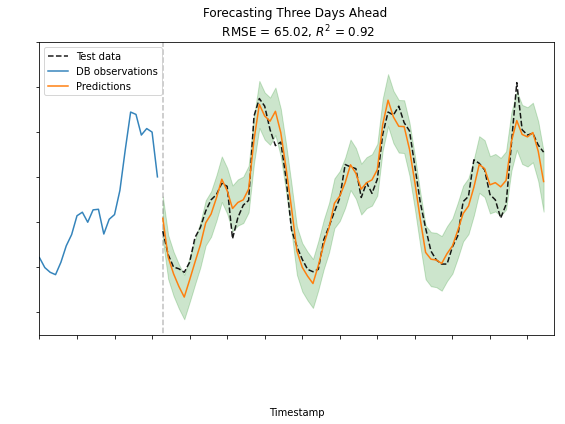

In [ ]:

# retrieve DB observations 
df_db = pd.read_sql_query("select time::timestamp,h1 from electricity where time > '2014-12-17 01:00:00';", conn)
T = len(df_db)
    

# plot Prediction

plt.figure(figsize = (8,6))
predict_range = len(df['prediction'])
plt.plot(np.arange(T,T+predict_range),data_test['h1'],'k--', label = 'Test data', alpha = 0.9)
plt.plot(np.arange(T), df_db['h1'],'-', label = 'DB observations', alpha = 0.9)
plt.plot( np.arange(T,T+predict_range),df['prediction'],'-' ,label = 'Predictions')
plt.fill_between( np.arange(T,T+predict_range),df['ub'],df['lb'], alpha = 0.2,color = 'green' )
plt.vlines(T,0,2000, linestyle = 'dashed', color= 'grey', alpha = 0.5)
plt.ylim([100,1400])
plt.xlim([0,4*24])
plt.xlabel('Timestamp')
plt.title('Forecasting Three Days Ahead \n RMSE = %.2f, $R^2$ = %.2f'%(rmse(df['prediction'],data_test['h1']), r2(data_test['h1'],df['prediction'],)))
plt.legend()
plt.yticks(color = 'white')
plt.xticks(np.arange(0,T+predict_range+1,7),np.concatenate([df_db['time'].dt.strftime('%m/%d/%y %H:%M'),pd.to_datetime(data_test['time'].values).strftime('%m/%d/%y %H:%M')])[::7], rotation=45, color = 'white')
plt.tight_layout()
plt.show()





Pleasingly, **tspDB** can predict 72 hours (i.e. three days) with reasonable accuracy. (RMSE of 65.02). Not only that, the lower and upper bounds seem to capture the variation in the observations where ~ 95% of observations are within the confidence interval.


---




Note that **tspDB** allows you to be more conservative in your estimate and set a higher confidence interval using the option ` c => `. For example, we can set the confidence interval to 99.5% as follows:




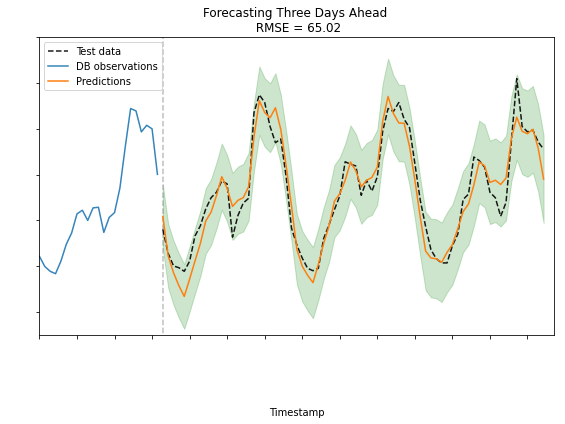

In [ ]:
# Forecast the next three days
df = pd.read_sql_query("select * from  predict('electricity','h1','2014-12-18 01:00:00'\
,'2014-12-21  00:00:00','pindex1', c=> 99.5);", conn)


%matplotlib inline
# plot Prediction


plt.figure(figsize = (8,6))

predict_range = len(df['prediction'])
plt.plot(np.arange(T,T+predict_range),data_test['h1'],'k--', label = 'Test data', alpha = 0.9)
plt.plot(np.arange(T), df_db['h1'],'-', label = 'DB observations', alpha = 0.9)
plt.plot( np.arange(T,T+predict_range),df['prediction'],'-' ,label = 'Predictions')
plt.fill_between( np.arange(T,T+predict_range),df['ub'],df['lb'], alpha = 0.2,color = 'green' )
plt.vlines(T,0,2000, linestyle = 'dashed', color= 'grey', alpha = 0.5)
plt.ylim([100,1400])
plt.xlim([0,4*24])
plt.xlabel('Timestamp')
plt.title('Forecasting Three Days Ahead \n RMSE = %.2f'%(rmse(df['prediction'],data_test['h1'] )))
plt.legend()
plt.yticks(color = 'white')
plt.xticks(np.arange(0,T+predict_range+1,7),np.concatenate([df_db['time'].dt.strftime('%m/%d/%y %H:%M'),pd.to_datetime(data_test['time'].values).strftime('%m/%d/%y %H:%M')])[::7], rotation=45, color = 'white')
plt.tight_layout()
plt.show()




The same Process can be repeated for other houses as seen below:


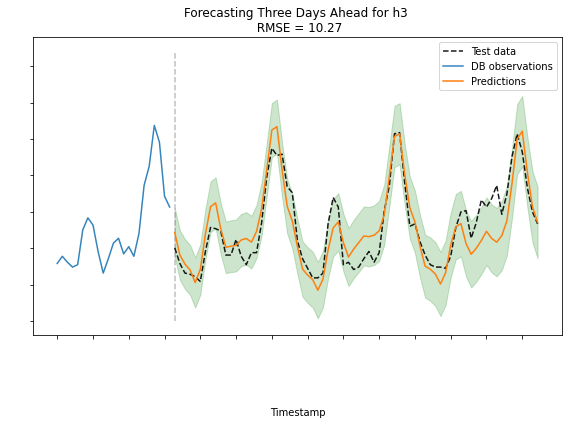

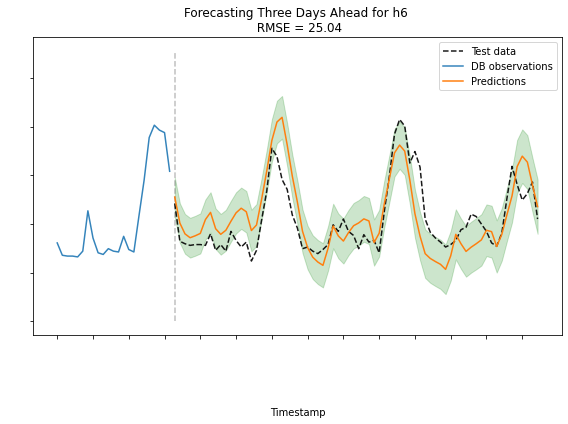

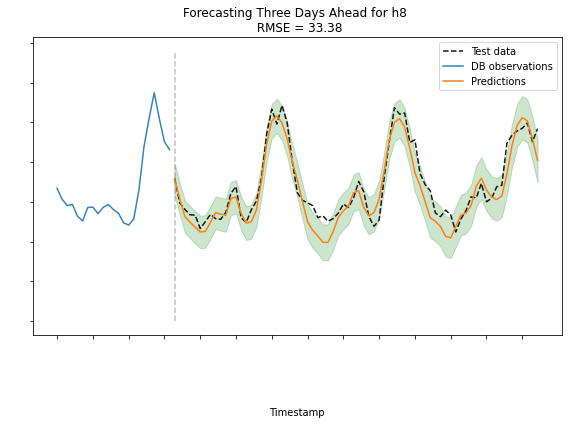

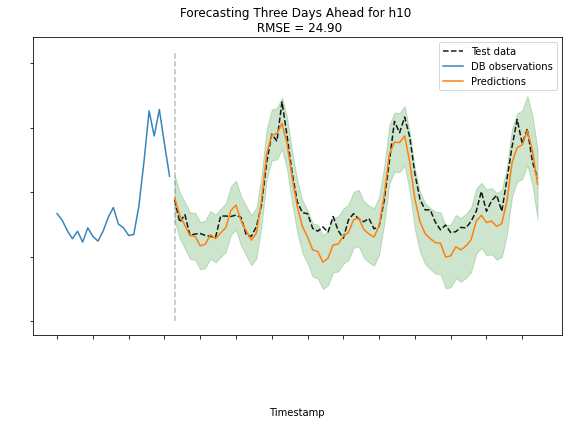

In [ ]:
%matplotlib inline

#plot Prediction
for i in [3,6,8,10]:
    house ='h'+str(i)
    df = pd.read_sql_query("select * from predict('electricity','%s','2014-12-18 01:00:00'\
,'2014-12-21  00:00:00','pindex1');"%(house), conn)
    df_db = pd.read_sql_query("select time::timestamp,%s from electricity where time > '2014-12-17 01:00:00';"%(house), conn)
    T = len(df_db)
    plt.figure(figsize = (8,6))
    predict_range = len(df['prediction'])
    plt.plot(np.arange(T,T+predict_range),data_test[house],'k--', label = 'Test data', alpha = 0.9)
    plt.plot(np.arange(T), df_db[house],'-', label = 'DB observations', alpha = 0.9)
    plt.plot( np.arange(T,T+predict_range),df['prediction'],'-' ,label = 'Predictions')
    plt.fill_between( np.arange(T,T+predict_range),df['ub'],df['lb'], alpha = 0.2,color = 'green' )
    plt.vlines(T,0,max(df['ub'])*1.2, linestyle = 'dashed', color= 'grey', alpha = 0.5)
    plt.xlabel('Timestamp')
    plt.title('Forecasting Three Days Ahead for %s \n RMSE = %.2f'%(house, rmse(df['prediction'],data_test[house] )))
    plt.legend()
    plt.yticks(color = 'white')
    plt.xticks(np.arange(0,T+predict_range+1,7),np.concatenate([df_db['time'].dt.strftime('%m/%d/%y %H:%M'),pd.to_datetime(data_test['time'].values).strftime('%m/%d/%y %H:%M')])[::7], rotation=45, color = 'white')
    plt.tight_layout()
    plt.show()




### Use Case II: Retail Demand

In this use case, we will showcase tspDB’s statistical performance when dealing with a more challenging prediction task. In particular, we want to predict Walmart’s sales data for the next 28 weeks (~ 6 months). This is challenging for three reasons: 
1. The observations data (i.e., sales data) used for training is incomplete and noisy.
2. These observations are censored because the sale number is affected by what the store has in stock (e.g., the store might have stocked only 4 pillows hence the number of pillows sold cannot exceed 4).
3. The sale of each product is an integer quantity, which is often modeled as a Poisson process. This might lead to degradation in the model’s performance if a different observation model (e.g., Gaussian) is assumed. 

We will show below that tspDB does very well when it comes to both forecasting and imputing the sales data.  Particularly, we will build a prediction index on the table `retail`, on which 25% of its entries were artificially masked. Then we will forecast the next 28 weeks of sales data.
 
 ----

#### Inspect data

First, we will inspect the table `retail`. The table contains the weekly sales for several departments (~90) across 10 Walmart stores. Each sales data point for each department/store is recorded in a separate column (e.g., `s1_d1` represents the sale data for department #1 at store #1). Each row represents the sales at the week starting at the day indicated by the column `time`. 

For example, look at the last 10 entries in the table:

In [ ]:
# lets query our table `electricity` to inspect its data
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from retail order by time  limit 10;", conn)
conn.close()
df

,time,s1_d1,s1_d2,s1_d3,s1_d4,s1_d5,s1_d6,s1_d7,s1_d8,s1_d9,...,s10_d87,s10_d90,s10_d91,s10_d92,s10_d93,s10_d94,s10_d95,s10_d96,s10_d97,s10_d98
0,2010-02-05,24924.50,50605.27,NaN,39954.04,32229.38,5749.03,21084.08,40129.01,16930.99,...,26394.89,16873.50,16363.10,54538.90,1337.33,22.15,77349.87,10576.00,6242.07,74.00
1,2010-02-12,46039.49,44682.74,NaN,NaN,NaN,9135.00,18310.31,37334.83,NaN,...,22280.68,16145.65,14371.53,NaN,1482.82,1531.13,NaN,NaN,NaN,181.25
2,2010-02-19,41595.55,47928.89,11523.47,36826.95,26468.27,NaN,19985.20,38717.60,15880.85,...,22896.50,15874.73,NaN,48087.25,NaN,3627.75,71524.04,NaN,5676.73,9.00
3,2010-02-26,19403.54,44292.87,11135.17,NaN,24101.89,5244.56,17224.22,35318.20,NaN,...,21536.65,16752.37,13372.08,52140.66,NaN,-12.74,75904.32,9830.56,5653.97,24.50
4,2010-03-05,NaN,48397.98,12275.58,NaN,NaN,4221.25,19659.70,38776.09,24064.70,...,22496.77,NaN,13008.35,53637.96,NaN,4.52,74608.89,NaN,NaN,11.00
5,2010-03-12,21043.39,43751.94,10123.45,32668.67,NaN,NaN,21529.14,NaN,25605.58,...,NaN,NaN,13902.44,51739.23,NaN,NaN,77090.23,8538.63,NaN,27.50
6,2010-03-19,22136.64,NaN,9001.37,34118.11,22632.57,4906.05,NaN,34188.52,33367.99,...,21040.04,15115.78,NaN,NaN,1445.48,1.13,NaN,9063.40,5832.94,39.46
7,2010-03-26,26229.21,41892.55,10366.85,NaN,38971.89,7468.33,16254.21,33581.72,27897.97,...,19381.11,14496.36,12780.09,NaN,1233.22,16.95,71879.38,9568.08,5425.84,43.64
8,2010-04-02,57258.43,47450.50,11157.08,37809.49,29967.92,NaN,22427.62,38151.58,25435.02,...,21050.60,16754.20,12648.80,49222.36,1462.10,4.52,69316.57,9656.81,NaN,14.25
9,2010-04-09,42960.91,46549.73,10179.29,NaN,18516.45,4428.80,20516.64,NaN,26113.67,...,19294.07,15493.41,12976.43,50255.73,1357.50,1.13,72872.50,9382.93,5498.87,77.00


Let's plot one of these columns that has a few missing entries, say `s4_d1` :

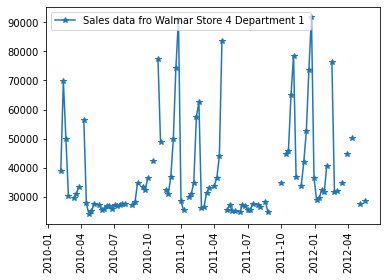

In [ ]:
# lets query our table `electricity` to inspect its data
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select time,s4_d1 from retail order by time limit 2000;", conn)
conn.close()
plt.plot(df['time'], df['s4_d1'], '-*' ,label = 'Sales data fro Walmar Store 4 Department 1 ')
plt.xticks(rotation = 90)
plt.legend()
# plt.xlim([pd.Timestamp('2011-12-18 00:00:00'),pd.Timestamp('2014-12-18 00:00:00')])
plt.show()


#### Build Prediction Index
Like  the first use case, we will create a **prediction index** which we will call `pindex_retail` on the columns (`s1_d1`, ..., `s10_d98`). 

In [ ]:
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
# to get the column names
df = pd.read_sql_query("select * from retail order by time DESC limit 1;", conn)
columns = '{"'+'","'.join(df.columns[1:])+'"}'
cursor.execute("""select create_pindex('retail', 'time','"""+columns+"""','pindex_retail', col_to_row_ratio => 5);""")
conn.commit()
conn.close()

#### Forecast Future Values
Let's again use **tspDB's** prediction functionality.  Let's forecast the next **28** weeks for the time series `s4_d1` and compare it with the test data.

First, let's load the test data from the file `retail_data_test.csv`



In [ ]:
weeks = 28
data_test = pd.read_csv('demo_data_v3/data/retail_data_test.csv', sep = ',').iloc[:weeks]

Then, let's use **tspDB's** function `predict_range` to predict the time series `s4_d1` from  `2012-05-25` to `2012-10-26`. The query used is 

`select * from predict_range('retail','s4_d1','2012-05-25' ,'2012-10-26','pindex_retail')`


In [ ]:
conn = psycopg2.connect(conn_string)
# Forecast the next three days
df = pd.read_sql_query("select * from predict('retail','s4_d1','2012-05-25' ,'2012-10-26','pindex_retail');", conn)

Let's visualize the predictions along with the actual observations:

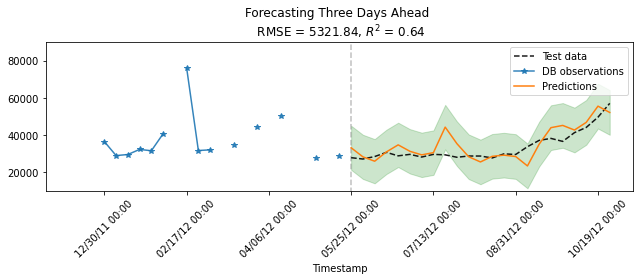

In [ ]:
# retrieve DB observations 
df_db = pd.read_sql_query("select time::timestamp,s4_d1 from retail where time > '2011-12-25' order by time;", conn)
T = len(df_db)
mean = pd.read_sql_query("select AVG(s4_d1) from retail ;", conn).values[0][0]
# plot Prediction

plt.figure(figsize =(9,4))
predict_range = len(df['prediction'])
plt.plot(np.arange(T,T+predict_range),data_test['s4_d1'],'k--', label = 'Test data', alpha = 0.9)
plt.plot(np.arange(T), df_db['s4_d1'],'-*', label = 'DB observations', alpha = 0.9)
plt.plot( np.arange(T,T+predict_range),df['prediction'],'-' ,label = 'Predictions')
plt.fill_between( np.arange(T,T+predict_range),df['ub'],df['lb'], alpha = 0.2,color = 'green' )
plt.vlines(T,0,10*max(df['ub']), linestyle = 'dashed', color= 'grey', alpha = 0.5)
plt.xlabel('Timestamp')
plt.title('Forecasting Three Days Ahead \n RMSE = %.2f, $R^2$ = %.2f'%(rmse(df['prediction'],data_test['s4_d1']), r2(data_test['s4_d1'],df['prediction'],mean)))
plt.legend()
plt.ylim(10000,90000)
plt.xlim(-5,T+predict_range+1)
plt.xticks(np.arange(0,T+predict_range+1,7),np.concatenate([df_db['time'].dt.strftime('%m/%d/%y %H:%M'),pd.to_datetime(data_test['Date'].values).strftime('%m/%d/%y %H:%M')])[::7], rotation=45)
plt.tight_layout()
plt.show()




 We notice that even though **tspDB** is forecasting 28 weeks into the future, it manages to capture the future dynamics of the sales data. 
 


---


 #### Impute Missing Values



 Let's take a further look at how does tspDB do when it comes to imputing missing values. We will impute the same time series `s4_d1` for the first 2 year (2/2010 to 12/2011), by again using the `predict_range` functionality. 

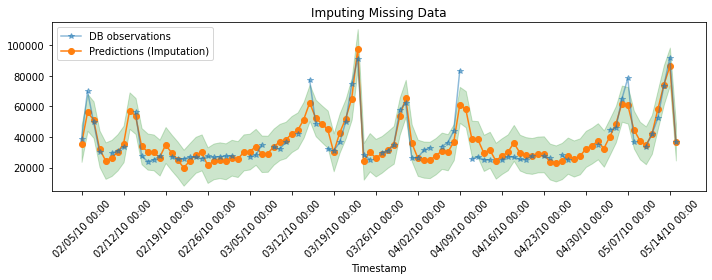

In [ ]:

%matplotlib inline
conn = psycopg2.connect(conn_string)
# Forecast the next three days
df = pd.read_sql_query("select * from predict('retail','s4_d1','2010-02-05' ,'2011-12-31','pindex_retail');", conn)
df_db = pd.read_sql_query("select time::timestamp,s4_d1 from retail where time >= '2010-02-05' and time <= '2011-12-31' order by time ;", conn)
T = len(df_db)
plt.figure(figsize=(10,4))
plt.plot(np.arange(T),list(df_db['s4_d1'].values),'*-', label = 'DB observations', alpha = 0.5, zorder = 4)
plt.plot( np.arange(T),df['prediction'],'o-' ,label = 'Predictions (Imputation)')
plt.fill_between( np.arange(T),df['ub'],df['lb'], alpha = 0.2,color = 'green' )
    
# plt.vlines(T,0,2000, linestyle = 'dashed', color= 'grey', alpha = 0.5)
plt.ylim(0.2*np.nanmin(df_db['s4_d1']),1.25*np.nanmax(df_db['s4_d1']))
plt.xlabel('Timestamp')
plt.title('Imputing Missing Data')
plt.legend()
T = len(df_db)
predict_range = len(df)
plt.xticks(np.arange(0,T+1,7),df_db['time'].dt.strftime('%m/%d/%y %H:%M'), rotation=45)
plt.tight_layout()
plt.show()


We can also visually compare with the true observations that we have masked in the DB. First we need to load the compelete observations.


In [ ]:
weeks = 28
data_com = pd.read_csv('demo_data_v3/data/retail_data_train.csv', sep = '\t', header = None)
data_com.columns = data_test.columns

Then plot both the true values and the estimates for the missing data:

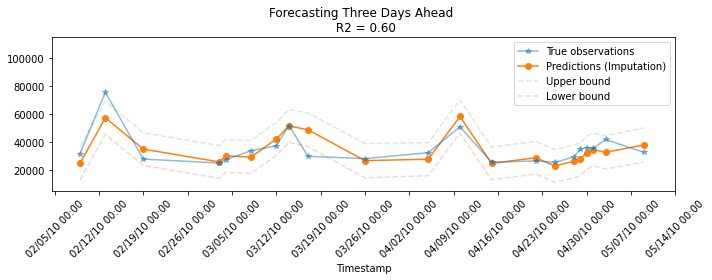

In [ ]:

%matplotlib inline
conn = psycopg2.connect(conn_string)
# Forecast the next three days
plt.figure(figsize=(10,4))
mask = np.isnan(df_db['s4_d1'])
plt.plot(data_com['s4_d1'][:T][mask],'*-', label = 'True observations', alpha = 0.5, zorder = 4)
plt.plot(df['prediction'][mask],'o-' ,label = 'Predictions (Imputation)')
plt.plot(  df['ub'][mask],'--', label = 'Upper bound', alpha = 0.2)
plt.plot( df['lb'][mask], '--',label = 'Lower bound', alpha = 0.2)
# plt.vlines(T,0,2000, linestyle = 'dashed', color= 'grey', alpha = 0.5)
plt.ylim(0.2*np.nanmin(df_db['s4_d1']),1.25*np.nanmax(df_db['s4_d1']))
plt.xlabel('Timestamp')
plt.title('Forecasting Three Days Ahead \n R2 = %.2f'%(r2(data_com['s4_d1'][:T][np.isnan(df_db['s4_d1'])], df['prediction'][np.isnan(df_db['s4_d1'])])))
plt.legend()
T = len(df_db)
predict_range = len(df)
plt.xticks(np.arange(0,T+1,7),df_db['time'].dt.strftime('%m/%d/%y %H:%M'), rotation=45)
plt.tight_layout()
plt.show()



This visually shows that we do indeed impute the missing observations with good accuracy.

### Use Case III: Financial Data 

In the third use case, we will briefly show that **tspDB** can work in yet another domain with different temporal dynamics. Specifically, we will work on financial data and show that we can forecast the daily stock prices for 30 days ahead (one day at a time) with great statistical accuracy.

#### Inspect data

First, we will inspect the table `financail`. The table contains the daily prices for 839 publicly listed stocks. Each stock is recorded in a separate column (e.g. `stock_1`). Each row represents the stock price at a particular working day (stored here as an integer for convenience)

For example, look at the last ten entries in the table:

In [5]:
# lets query our table `electricity` to inspect its data
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from financial order by time DESC limit 10;", conn)
conn.close()
df

,time,stock_1,stock_2,stock_3,stock_4,stock_5,stock_6,stock_7,stock_8,stock_9,...,stock_830,stock_831,stock_832,stock_833,stock_834,stock_835,stock_836,stock_837,stock_838,stock_839
0,3812,78.25,31.11,162.59,173.26,83.67,70.78,339.17,76.470,26.270000,...,54.04,56.48,92.04,110.77,78.88,41.00,627.36,93.16,202.66,34.235
1,3811,79.21,30.70,163.00,173.70,84.80,71.14,350.72,76.585,26.226667,...,54.16,56.80,92.47,110.30,78.68,41.57,633.81,93.37,203.51,34.700
2,3810,78.90,30.47,162.63,174.15,86.30,70.69,354.28,76.250,26.350000,...,54.62,57.10,93.02,111.77,78.16,42.12,635.44,95.67,207.32,35.285
3,3809,78.16,29.88,161.31,171.58,85.39,70.93,359.47,75.440,26.293333,...,54.18,56.80,91.89,110.78,78.67,41.98,637.10,95.00,200.64,34.830
4,3808,77.50,29.20,166.21,171.80,86.35,72.95,362.02,75.120,26.250000,...,54.44,56.12,92.25,110.47,78.40,42.62,666.00,94.53,199.92,34.700
5,3807,77.53,28.39,166.00,171.20,86.19,70.96,360.57,74.870,26.053333,...,54.58,56.02,92.40,110.58,78.23,42.53,650.10,94.67,198.78,34.615
6,3806,78.00,28.21,169.93,169.76,86.40,70.65,361.77,75.160,25.780000,...,54.48,55.75,92.60,109.72,77.55,43.75,646.59,94.25,200.44,33.645
7,3805,77.63,28.71,169.83,171.25,86.70,70.60,360.00,74.560,25.670000,...,54.25,55.76,92.16,110.00,76.86,43.92,648.70,94.75,198.65,33.245
8,3804,77.00,28.73,165.92,169.77,86.02,69.84,357.61,74.030,25.790000,...,53.88,55.67,91.03,108.84,76.26,43.60,644.90,92.93,185.88,32.960
9,3803,77.37,28.81,168.68,171.43,85.91,70.30,357.74,75.200,25.470000,...,54.45,55.62,91.24,109.42,75.58,43.18,647.00,94.03,183.39,33.760


Also, let's plot the daily prices for one of the companies, say `stock_2`

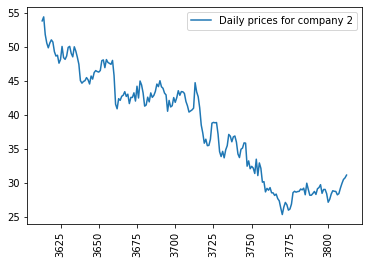

In [6]:
# lets query our table `electricity` to inspect its data
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select time,stock_2 from financial order by time DESC limit 200;", conn)
conn.close()
plt.plot(df['time'], df['stock_2'], '-' ,label = 'Daily prices for company 2')
plt.xticks(rotation = 90)
plt.legend()
# plt.xlim([pd.Timestamp('2011-12-18 00:00:00'),pd.Timestamp('2014-12-18 00:00:00')])
plt.show()




---


#### Build Prediction Index
Similar to the previous use cases, we will create a **prediction index** which we will call `pindex_fin` on the columns (`stock_1`, ..., `stock_839`). 

In [7]:
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from financial order by time DESC limit 10;", conn)
cursor = conn.cursor()
columns = '{"'+'","'.join(df.columns[1:])+'"}'
cursor.execute("""select create_pindex('financial', 'time','"""+columns+"""','pindex_fin', auto_update => false);""")
conn.commit()
conn.close()

#### Forecast Future Values
Let's now use **tspDB's** prediction functionality. Specifically, we will forecast the next **30** days for the time series `stock_2` and compare it with the test data.

First, let's load the test data from the file `financial_data_test.csv`



In [8]:
weeks = 30
data_test = pd.read_csv('demo_data_v3/data/financial_test.csv', sep = ',').iloc[:weeks]
end_time = data_test['time'].max()

Then, let's use **tspDB's** function `predict` to predict the time series `stock_2` one step at a time. after each prediction, we will insert the true price from the test file into the DB as follows.


In [9]:
prediction = []
LB = []
UB = []
conn = psycopg2.connect(conn_string)
insert = "insert into financial values (%s)"
for i in data_test.values[:30]:
    pdf = pd.read_sql_query("select * from predict('financial','stock_2',%s ,'pindex_fin');"%int(i[0]), conn)
    prediction.append(pdf.values[0][0])
    LB.append(pdf.values[0][1])
    UB.append(pdf.values[0][2])
    
    cursor = conn.cursor()
    cursor.execute(insert %(','.join([str(k) for k in i[:]])))
    conn.commit()
    conn.close()
    conn = psycopg2.connect(conn_string)
conn.close()

Let's visualize the predictions along with the actual observations:

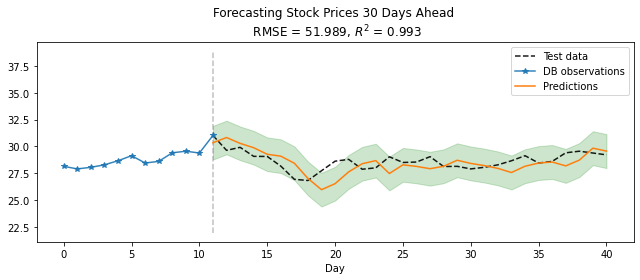

In [10]:
# retrieve DB observations 
conn = psycopg2.connect(conn_string)
df_db = pd.read_sql_query("select time,stock_2 from financial where time > 3830  and time <3842 order by time;", conn)


T = len(df_db)
mean = pd.read_sql_query("select AVG(stock_2) from financial ;", conn).values[0][0]
conn.close()
# plot Prediction
predict_range = len(prediction)
plt.figure(figsize =(9,4))
plt.plot(np.arange(T,T+predict_range),data_test['stock_2'],'k--', label = 'Test data', alpha = 0.9)
plt.plot(np.arange(T+1), list(df_db['stock_2'])+[data_test['stock_2'][0]],'-*', label = 'DB observations', alpha = 0.9)
plt.plot( np.arange(T,T+predict_range),prediction,'-' ,label = 'Predictions')
plt.fill_between( np.arange(T, T+predict_range),UB, LB, alpha = 0.2,color = 'green' )
plt.vlines(T,0.9*min(LB),1.2*max(UB), linestyle = 'dashed', color= 'grey', alpha = 0.5)
plt.xlabel('Day')
plt.title('Forecasting Stock Prices 30 Days Ahead \n RMSE = %.3f, $R^2$ = %.3f'%(rmse(prediction,data_test['stock_1']), r2(data_test['stock_2'],prediction,mean)))
plt.legend()
plt.xlim(-2,T+predict_range+1)
plt.tight_layout()
plt.show()





## Part II: tspDB's Uncertainity Quantification Capabilities.

Here, we showcase **tspDB's** ability to estimate the underlying variance from highly noisy observations. 

Table `synthetic_var` contains observations generated from a Gaussian process with a time-varying mean (synthetically generated by a sum of harmonics) and a time-varying variance (Also synthetically generated by a sum of harmonics). The underlying mean and variance are included in the table to validate tspDB's predictions. 

Specifically, our time series data consist of 4 columns, namely:

**1. `time`**: (int) this column represents the time index as integers.

**2. `ts`:** (float) Where the observation of the time series are stored.

**3. `means`:** (float) Where the underlying mean of the time series is stored. Note that since this data is synthetically generated, we *know*  the underlying mean of the generating process.

**4. `var`:** (float) Where the underlying time-varying variance of our time series is stored


Let's take a look at the few last entries in the table: 

In [ ]:
conn = psycopg2.connect(conn_string)
df = pd.read_sql_query("select * from synthetic_var order by time DESC limit 10;", conn)
conn.close()
df

,time,ts,means,var
0,998999,0.885135,0.905010,0.122488
1,998998,0.845429,0.905045,0.122468
2,998997,1.151417,0.905079,0.122449
3,998996,1.088256,0.905114,0.122430
4,998995,0.875478,0.905149,0.122410
5,998994,1.395005,0.905184,0.122391
6,998993,1.386438,0.905218,0.122372
7,998992,0.672902,0.905253,0.122353
8,998991,0.981625,0.905288,0.122333
9,998990,1.059042,0.905323,0.122314


Let's also take a look at the observations, its underlying mean, and its underlying variance.

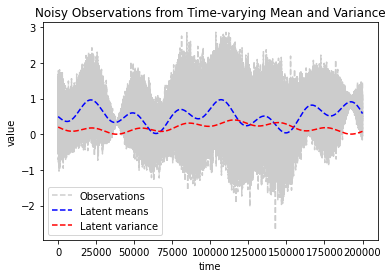

In [ ]:
conn = psycopg2.connect(conn_string)
N = 200000
query = "select * from synthetic_var where time >= 0 and time <= %s;"%(N-1)
db_df = pd.read_sql_query(query, conn)

conn.close()


plt.figure()
plt.title('Estimating Latent Mean')
plt.plot(db_df['time'], db_df['ts'],'--k', label = 'Observations', alpha = 0.2)
plt.plot( db_df['means'][:N],'--b', label = 'Latent means', alpha = 1.0)
plt.plot(db_df['time'], db_df['var'][:N],'--r', label = 'Latent variance')
plt.ylabel('value')
plt.xlabel('time')
plt.title('Noisy Observations from Time-varying Mean and Variance')
plt.legend()

As done before, we will create a prediction index that we will call `pindex_var`  on the column `ts`:



In [ ]:
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
cursor.execute("""select create_pindex('synthetic_var', 'time','{"ts"}','pindex_var');""")
conn.commit()
conn.close()

Now we will get **tspDB's** estimate of both the mean and variance. Since **tspDB** is using Gaussian approximation for estimating the confidence interval, we will use the width of the confidence interval to estimate the variance. Specifically, the interval width when the 95% confidence interval equals ~$1.96 \cdot \sigma$, where $ \sigma$ is the standard deviation.

We will plot the noisy observations (gray), the latent mean and variance (dotted blue and red lines, respectively), and tspDB's estimate of the latent mean and variance (solid blue and red lines, respectively).  

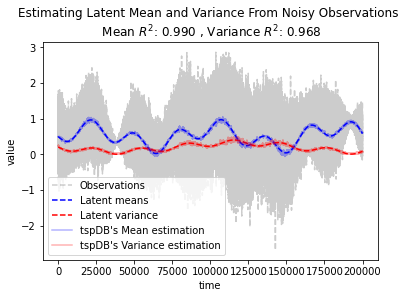

In [ ]:
conn = psycopg2.connect(conn_string)
%matplotlib inline
N = 200000
query = "select * from  predict('synthetic_var','ts',0,%s,'pindex_var');"%(N-1)
df = pd.read_sql_query(query, conn)
query = "select * from synthetic_var where time >= 0 and time <= %s;"%(N-1)
db_df = pd.read_sql_query(query, conn)

conn.close()

est_var = ((df['prediction'] - df['lb'])/norm.ppf(0.975))**2


plt.figure()
plt.plot(db_df['time'], db_df['ts'],'--k', label = 'Observations', alpha = 0.2)
plt.plot( db_df['means'][:N],'--b', label = 'Latent means', alpha = 1.0)
plt.plot(db_df['time'], db_df['var'][:N],'--r', label = 'Latent variance')
plt.plot(df['prediction'], '-b',label = "tspDB's Mean estimation",alpha = 0.3)
plt.plot(db_df['time'], est_var,'-r', label = "tspDB's Variance estimation", alpha = 0.3)
plt.ylabel('value')
plt.xlabel('time')
plt.title('Estimating Latent Mean and Variance From Noisy Observations \n Mean $R^2$: %.3f , Variance $R^2$: %.3f'%(r2_score(db_df['means'][:N], df['prediction'] ),r2_score(db_df['var'][:N],est_var)))
plt.legend()
plt.show()

The figure above shows that even though **tspDB** is unaware of the underlying dynamics of mean and variance, it successfully recover them with a high $R^2$ score from very noisy observations (shown in grey). 

## Part III: System Performance

### 1- Prediction queries latency

Now, we will measure the latency of the proposed predictive queries. Specifically, we will compare their latency with the latency of a standard `SELECT` query. We will use the table `synthetic_var` in this demo.

In [ ]:

# Prepare connection
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()

# Number of tests
N = 20
T = 998875*np.random.random(N).astype(int)
cursor.execute("select predict('synthetic_var','ts',998875,'pindex_var')")

# Measure SELECT latency
select_latency =[]
for i in T:
    t_ = time.time()
    cursor.execute("select * from synthetic_var where time =%s;"%(i))
    select_latency.append(time.time() - t_)
select_latency = np.mean(select_latency)

# Measure Predict Impute latency
predict_imp_latency =[]
for i in T:
    t_ = time.time()
    cursor.execute("select  predict('synthetic_var','ts',%s,'pindex_var', uq => false)"%(i))
    predict_imp_latency.append(time.time() - t_)
predict_imp_latency = np.mean(predict_imp_latency)

# Measure Predict Forecast latency
pedict_forecast_query = []
for i in T:
    t_ = time.time()
    cursor.execute("select  predict('synthetic_var','ts',998876,'pindex_var', uq => false)")
    pedict_forecast_query.append(time.time() - t_)
pedict_forecast_query = np.mean(pedict_forecast_query)

conn.close()


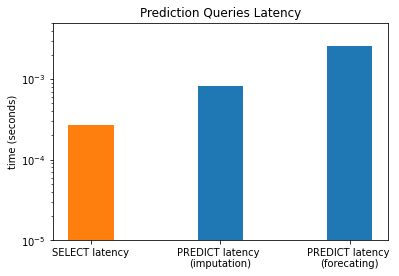

(3.0785537839658654, 9.766494498091173)

In [ ]:
# Plot

cm = 1
N = 3
fig, ax = plt.subplots()
ind = np.arange(3)   
width = .350         
p1 = ax.bar(ind, [select_latency,predict_imp_latency,pedict_forecast_query], width, bottom=0*cm)

ax.set_title('Prediction Queries Latency')
ax.set_xticks(ind)
ax.set_xticklabels(['SELECT latency','PREDICT latency \n(imputation)','PREDICT latency \n(forecating)'])
plt.ylabel('time (seconds)')
ax.autoscale_view()
ax.set_yscale('log')
plt.ylim(0.00001,0.0050)

p1[0].set_color('tab:orange')
plt.show()
predict_imp_latency/select_latency,pedict_forecast_query/select_latency

We can see from the figure above that the proposed predictive queries are of similar latency to a standard `SELECT` queries. Specicifcally, depending on machine configuration, tspDB's Predict queries remain only few times slower than SELECT queries (~3-18x)


### 2- Insert throughput

In this part, we will measure the time taken to build a prediction index. Specifically, we will show that creating a prediction index takes less (or similar) time when compared to inserting the same training data into a PostgreSQL table.
First we will create the same schemas we has before for the 4 tables. 

In [ ]:

# Create Schemas
conn = psycopg2.connect(conn_string)
cur = conn.cursor()
cur.execute(open("demo_data_v3/load_data.sql", "r").read())
conn.commit()
conn.close()




In [ ]:
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()

# Load Tables
electricity = pd.read_csv('demo_data_v3/data/electricity.csv', sep = '\t')
synth = pd.read_csv('demo_data_v3/data/synthetic_var.csv', sep = '\t').iloc[:,:]

#Insert time into Postgres

## Electricity TABLE
# delete table records and table indices
cursor.execute("Delete  from  electricity;")
cursor.execute("select  delete_pindex(index_name) from (select index_name from  list_pindices() where relation = '%s') as a;"%('electricity'))
conn.commit()
# Bulk Insert, data exist on server side ()
t = time.time()
cursor.execute("COPY electricity from '/content/demo_data_v3//data/electricity.csv' ")
conn.commit()
postgres_elec_insert_time = time.time()-t

## Synthetic  TABLE
# delete table records and table indices
cursor.execute("Delete  from  synthetic_var;")
cursor.execute("select  delete_pindex(index_name) from (select index_name from  list_pindices() where relation = '%s') as a;"%('synthetic_var'))
conn.commit()
# Time Bulk Insert, data exist on server side ()
t = time.time()
cursor.execute("COPY synthetic_var from '/content/demo_data_v3/data/synthetic_var.csv' ")
conn.commit()
# bulk_insert(synth, 'synthetic_var_test', conn_string)
postgres_synth_insert_time = time.time()-t

## Financial  TABLE
# delete table records and table indices
cursor.execute("Delete  from  financial;")
cursor.execute("select  delete_pindex(index_name) from (select index_name from  list_pindices() where relation = '%s') as a;"%('financial'))
conn.commit()
# Time Bulk Insert, data exist on server side (data transmission over network is not needed)
t = time.time()
cursor.execute("COPY financial from '/content/demo_data_v3/data/financial.csv' ")
# bulk_insert(synth, 'synthetic_var_test', conn_string)
conn.commit()
postgres_fin_insert_time = time.time()-t
conn.close()


# # Prediction index insert time
# # Prepare Connection 
conn = psycopg2.connect(conn_string)
cursor = conn.cursor()
# warm start, to avoid including time to load the functionality 
cursor.execute("""select create_pindex('electricity', 'time','{"h10"}','pindex_test');""")
conn.commit()

t = time.time()
cursor.execute("""select create_pindex('electricity', 'time','{"h1"}','pindex_test1', k_var => 0);""")
conn.commit()
pindex_elec_insert_time = time.time()-t

t = time.time()
cursor.execute("""select create_pindex('electricity', 'time','{"h1"}','pindex_test1', k_var => 0);""")
conn.commit()
pindex_elec_insert_time = time.time()-t


t = time.time()
cursor.execute("""select create_pindex('synthetic_var', 'time','{"ts"}','pindex_test2', k_var => 0);""")
conn.commit()
pindex_synth_insert_time = time.time()-t


t = time.time()
cursor.execute("""select create_pindex('financial', 'time','{"stock_1"}','pindex_test2', k_var => 0);""")
conn.commit()
pindex_fin_insert_time = time.time()-t


# conn.close()

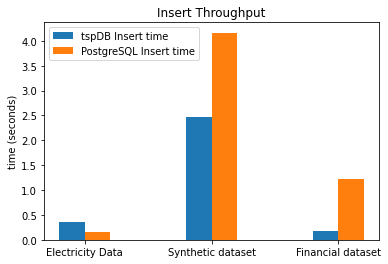

In [ ]:
cm = 1
N = 3
fig, ax = plt.subplots()
ind = np.arange(3)   
width = .2         
p1 = ax.bar(ind-0.1, [pindex_elec_insert_time, pindex_synth_insert_time,pindex_fin_insert_time], width, bottom=0*cm)
p2 = ax.bar(ind+0.1, [postgres_elec_insert_time, postgres_synth_insert_time, postgres_fin_insert_time], width, bottom=0*cm)
ax.legend((p1,p2),('tspDB Insert time', 'PostgreSQL Insert time'))

ax.set_title('Insert Throughput')
ax.set_xticks(ind)
ax.set_xticklabels(['Electricity Data','Synthetic dataset','Financial dataset'])
plt.ylabel('time (seconds)')
ax.autoscale_view()
plt.show()


The results above show that creating a single-column prediction index takes less or similar time when compared to inserting data into a PostgreSQL table. Hence, the added computational overhead should not be a bottleneck in the system performance. 

# Conclusion

**In this demonstration, we showed tspDB's robust and efficient predictive capabilities. We showed that it is indeed possible to build a system that integrates predictive capabilities and is:**
1. **Computationally performant:** the system has high insert throughput and thus does not compromise the DB system performance, and its predictive queries are of latency comparable to `SELECT` point queries.  
2. **Statistically accurate:** the system predictions are accurate even with data quality issues common in time series such as missing values and highly noisy observations.
